celebahq
* mean = [0.5157, 0.4160, 0.3625]
* std = [0.3005, 0.2712, 0.2657]

ffhq
* mean = [0.5189, 0.4236, 0.3797]
* std = [0.2820, 0.2550, 0.2557]

celebahq_gamma_1.5_1.7
* mean = [0.0806, 0.0599, 0.0506]
* std = [0.0789, 0.0663, 0.0623]

ffhq_gamma_1.5_1.7
* mean = [0.0785, 0.0590, 0.0518]
* std = [0.0750, 0.0634, 0.0611]

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

# hr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/ffhq_256_256_gamma_1.5_1.7/hr'
# lr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/ffhq_256_256_gamma_1.5_1.7/lr'
# hiseq_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/ffhq_256_256_gamma_1.5_1.7/hiseq'

hr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/celebahq_256_256_gamma_1.5_1.7/hr'
lr_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/celebahq_256_256_gamma_1.5_1.7/lr'
hiseq_path = '/home/allen/Documents/MIE288/sr3_server4/data/dark/celebahq_256_256_gamma_1.5_1.7/hiseq'

hr_files = [p for p in Path('{}'.format(hr_path)).glob(f'**/*')]
hr_files=sorted(hr_files, key=lambda i: int(i.stem))

lr_files = [p for p in Path('{}'.format(lr_path)).glob(f'**/*')]
lr_files=sorted(lr_files, key=lambda i: int(i.stem))

hiseq_files = [p for p in Path('{}'.format(hiseq_path)).glob(f'**/*')]
hiseq_files=sorted(hiseq_files, key=lambda i: int(i.stem))

In [2]:
mean_hr = [0.5171085596084595, 0.4166611135005951, 0.3634870648384094]
std_hr = [0.30106019973754883, 0.2723495662212372, 0.26739370822906494] 

mean_lr = [0.08092497289180756, 0.06012996658682823, 0.050999607890844345] 
std_lr = [0.07921801507472992, 0.06673561781644821, 0.06303226947784424] 

mean_hiseq = [0.47571495175361633, 0.46652695536613464, 0.457474946975708]  
std_hiseq = [0.30860862135887146, 0.3171645402908325, 0.3253151774406433]  

transform_hr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_hr, std_hr)
])

transform_lr = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_lr, std_lr)
])

transform_hiseq = T.Compose([
    T.ToTensor(),
    T.Normalize(mean_hiseq, std_hiseq)
])

In [4]:
def to_tensor_and_normalize(files, mode='LR'):
    img_ls = []

    for file in tqdm(files):
        img = Image.open(file).convert('RGB')
        if mode == 'HR':
            img = transform_hr(img)
        elif mode == 'LR':
            img = transform_lr(img)
        else:
            img = transform_hiseq(img)
        img_ls.append(img)
    
    img_ls = torch.stack(img_ls, 0)

    return img_ls

In [5]:
hr_imgs = to_tensor_and_normalize(hr_files, 'HR')
lr_imgs = to_tensor_and_normalize(lr_files, 'LR')
hiseq_imgs = to_tensor_and_normalize(hiseq_files, 'Hiseq')

100%|██████████| 30000/30000 [01:27<00:00, 344.20it/s]


In [6]:
def find_y_avg(imgs):
    y_list = []
    
    for i in tqdm(range(imgs.shape[0])):
        y = 0.299*imgs[i,0,:,:] + 0.587*imgs[i,1,:,:] + 0.114*imgs[i,2,:,:]
        y_avg = np.average(y)
        y_list.append(y_avg)
    
    return np.array(y_list)

In [7]:
def calculate_mean_std(imgs):

    mean_ls = []
    std_ls = []
    
    channels = imgs.shape[1]

    for i in tqdm(range(channels)):
        all_pixels = imgs[:,i,:,:]
        
        std, mean = torch.std_mean(all_pixels)

        mean_ls.append(mean.item())
        std_ls.append(std.item())
    
    return mean_ls, std_ls
    

In [8]:
mean_hr, std_hr = calculate_mean_std(hr_imgs)
print(mean_hr)
print(std_hr)

mean_lr, std_lr = calculate_mean_std(lr_imgs)
print(mean_lr)
print(std_lr)

mean_hiseq, std_hiseq = calculate_mean_std(hiseq_imgs)
print(mean_hiseq)
print(std_hiseq)

100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


[-3.07046512659781e-08, -1.4499716094462656e-08, 3.118576685778862e-08]
[1.0, 1.0, 1.0]


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


[6.70691902016074e-09, -1.9496737557744837e-09, -1.502503899075691e-08]
[1.0, 1.0, 1.0]


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

[-2.0428837288477553e-08, 2.0280980450593233e-08, -3.1451229176582274e-08]
[1.0, 1.0, 1.0]


In [9]:
hr_y = find_y_avg(hr_imgs)
lr_y = find_y_avg(lr_imgs)
hiseq_y = find_y_avg(hiseq_imgs)

100%|██████████| 30000/30000 [00:09<00:00, 3209.57it/s]


In [21]:
hr_sample = hr_imgs[0].permute(1,2,0).numpy()/2 + 0.5
lr_sample = lr_imgs[0].permute(1,2,0).numpy()/2 + 0.5
hiseq_sample = hiseq_imgs[0].permute(1,2,0).numpy()/2 + 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


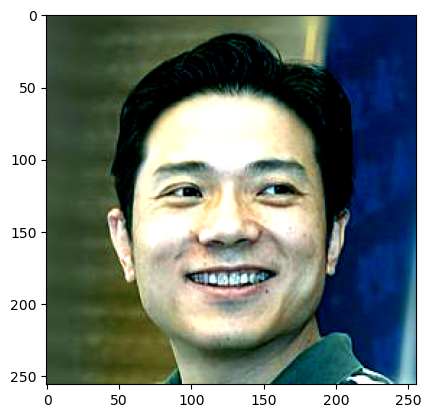

In [22]:
plt.imshow(hr_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


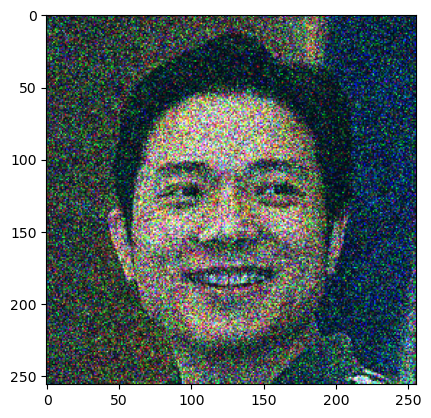

In [23]:
plt.imshow(lr_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


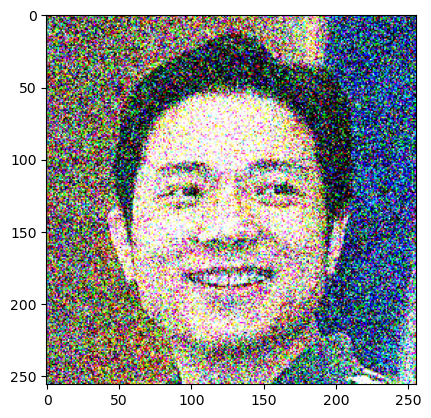

In [24]:
plt.imshow(hiseq_sample)

Text(0.5, 1.0, 'Y distribution of HR-norm imgs')

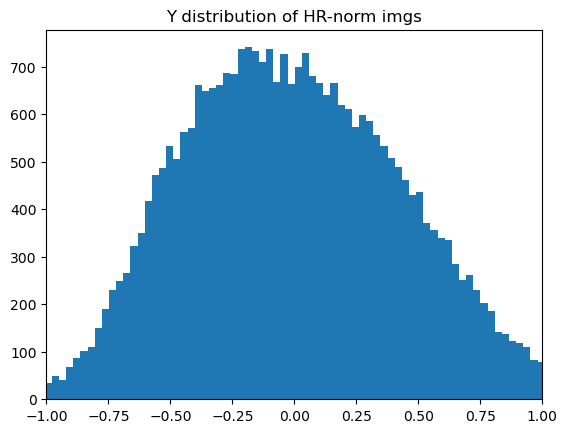

In [14]:
plt.hist(hr_y, bins=100)
plt.xlim(-1, 1)
plt.title('Y distribution of HR-norm imgs')


Text(0.5, 1.0, 'Y distribution of LR-norm imgs')

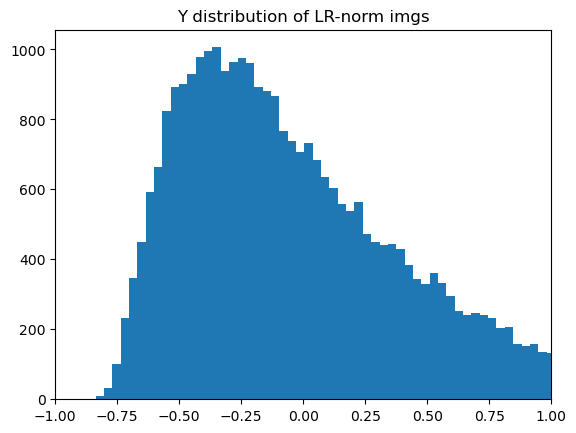

In [15]:
plt.hist(lr_y, bins=100)
plt.xlim(-1, 1)
plt.title('Y distribution of LR-norm imgs')

Text(0.5, 1.0, 'Y distribution of Hiseq-norm imgs')

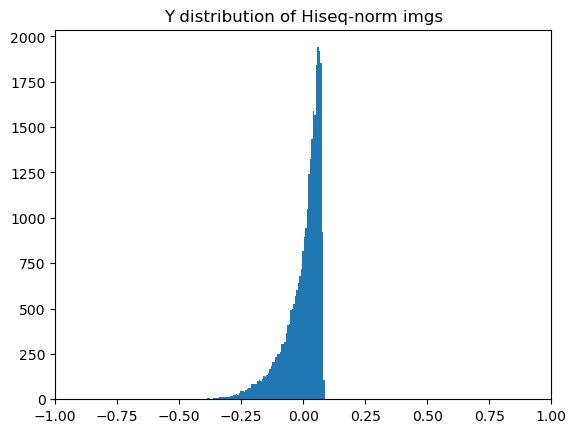

In [16]:
plt.hist(hiseq_y, bins=100)
plt.xlim(-1, 1)
plt.title('Y distribution of Hiseq-norm imgs')